# Differentiating Rollout Trajectories
Bayesian Optimization can be described entirely in 7 steps, adding nuance when necessary:
1. Gather initial samples
2. Initialize our model
3. Get the acquisition function $\alpha(x)$
4. Optimize the acquisition function
5. Sample new data based on results from the optimization of $\alpha(x)$ and update model
6. Repeat until budget is exhausted
7. Make final recommendation

### Desiderata
* Figure out how to update the model by reconditioning the current model on new observations
* Construct an API that leverages our computing framework while remaining free of dogmatism when it comes to implementing each step
* Elaborate on the nuances of incorporating rollout into the Bayesian Optimization algorithm.

In [1]:
using CovarianceFunctions
using GaussianDistributions
using LinearAlgebra
using Optim
using Plots

import Distributions

In [2]:
pyplot()
CF = CovarianceFunctions

CovarianceFunctions

In [14]:
bound = .5
X_init = vec([-.37 .37]);
Y_init = zeros(length(X_init));

## Step 2: Initializing Our Model
Our model of choice is a Gaussian process, which is completely defined by its mean function and covariance function.
$$
\begin{aligned}
m(\textbf{x}) &= \mathbb{E}[f(\textbf{x})],\\
k(\textbf{x}, \textbf{x'}) &= \mathbb{E}[(f(\textbf{x}) - m(\textbf{x}))(f(\textbf{x'}) - m(\textbf{x'}))]
\end{aligned}
$$
and we write the Gaussian process as
$$
f(\textbf{x}) \sim \mathcal{GP}(m(\textbf{x}), k(\textbf{x}, \textbf{x'}))
$$

Our covariance function of choice will be the squared exponential kernel, where the hyperparameters must be learned. For the time being, we'll set them manually.
<hr>
Below, we make use of some interesting developing packages, so further details are required when tracing out our computation.

In [23]:
ℓ = .5 # set to 0.5 for toy example
μ(x) = 0
Σ(x, y) = CF.Lengthscale(CF.EQ(), ℓ)(x, y)
GP = Gaussian(μ, Σ)
CGP = GP | (X_init, Y_init); # when conditioning, x_init must be a column vector

## Step 3: Get the Acquisition Function $\alpha(\textbf{x})$
Here, our acquisition function will be expected improvement, which is defined as:

$$
EI(\textbf{x}) = \mathbb{E} [max(f(\textbf{x}) - f(\textbf{x}^+), 0)]
$$

where $f(\textbf{x}^+)$ is the value of the best sample so far and $\textbf{x}^+$ is the location of that sample i.e. $\textbf{x}^+ = argmax_{x_{i} \in x_{1:n}}f(\textbf{x}_i)$. The expected improvement can be evaluated analytically under the GP model:

$$
EI(\textbf{x}) =
\left\{
\begin{array}{ll}
      (\mu(\textbf{x}) - f(\textbf{x}^+) - \xi)\Phi(Z) + \sigma(\textbf{x})\phi(Z) & \sigma(\textbf{x}) \gt 0 \\
      0 & \sigma(\textbf{x}) = 0 \\
\end{array} 
\right.
$$

where

$$
Z =
\left\{
\begin{array}{ll}
      \frac{\mu(\textbf{x}) - f(\textbf{x}^+) - \xi}{\sigma(\textbf{x})} & \sigma(\textbf{x}) \gt 0 \\
      0 & \sigma(\textbf{x}) = 0 \\
\end{array} 
\right.
$$

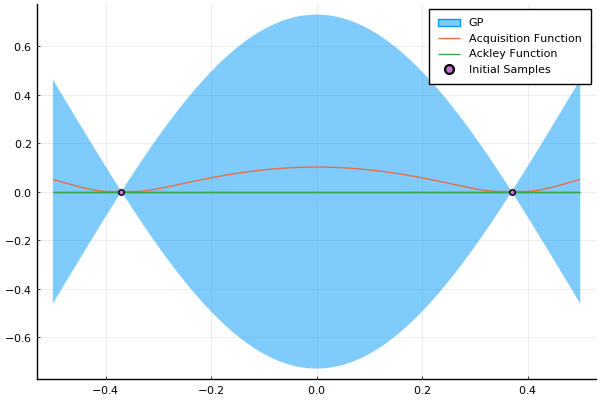

In [24]:
# First, let's grab x+ and f(x+)
fbest, fbest_ndx = findmax(Y_init)
xbest = X_init[fbest_ndx]

# Let's evaluate EI over our domain
grid = collect(-bound:.01:bound)
μ̂ = mean(CGP)
σ̂ = std(CGP)

function z(x, f⁺; ξ=0.1)
    return σ̂(x) > 0 ? (μ̂(x) - f⁺ - ξ) / σ̂(x) : 0
end

function ei(x, f⁺; ξ=0.1)
    z_eval = z(x, f⁺; ξ=ξ)
    normal = Distributions.Normal()
    normal_cdf_at_z = Distributions.cdf(normal, z_eval)
    normal_pdf_at_z = Distributions.pdf(normal, z_eval)
    σ̂eval = σ̂(x)
    
    return σ̂eval > 0 ? (μ̂(x) - f⁺ - ξ) * normal_cdf_at_z + σ̂(x)*normal_pdf_at_z : 0
end

# Now to plot the response surface
# We want to maximize expected improvement, but our optimization library deals primarily in
# minimization, therefore we seek to minimize the negation of expected improvement
plot(grid, μ̂.(grid), ribbon=2σ̂.(grid), label="GP")
plot!(grid, ei.(grid, fbest; ξ=.1), label="Acquisition Function")
plot!(grid, zeros(length(grid)), label="Ackley Function")
# plot!(grid, μ̂.(grid), ribbon=2σ̂.(grid), label="GP") # also plot multiple draws from GP
Plots.scatter!(X_init, Y_init, label="Initial Samples")

## Step 4: Optimize the Acquisition Function
Now that we have a functional handle on our acquisition function, we'll use this to propose our next sample location.

In [25]:
# Is it worthwhile keeping track of the best to date?
ei_fbest(x) = -ei(x[1], fbest) # want some auto differentiation here
result = optimize(ei_fbest, [0.0], LBFGS())
xnew = Optim.minimizer(result)
println("Minimum: $(Optim.minimum(result))\nMinimizer: $(Optim.minimizer(result))")

Minimum: -0.10105099060054887
Minimizer: [0.0]


## Step 5: Sample New Data Based on Results from the Optimization of $\alpha(x)$ and Update Model
Now we want to evaluate the objective function at our new proposed location.

In [28]:
push!(X_init, xnew[1])
push!(Y_init, 0)

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

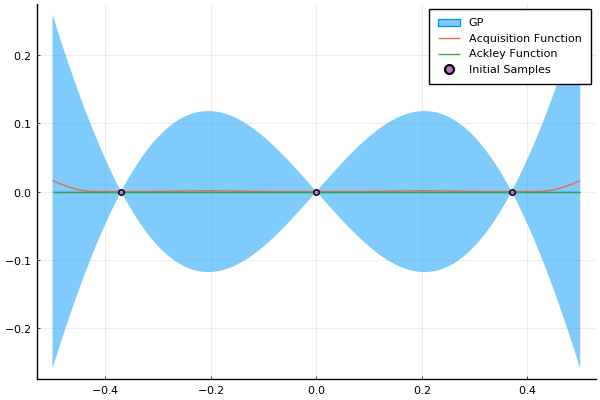

In [32]:
UCGP = Gaussian(μ, Σ) | (X_init, Y_init)
# First, let's grab x+ and f(x+)
fbest, fbest_ndx = findmax(Y_init)
xbest = X_init[fbest_ndx]

# Let's evaluate EI over our domain
grid = collect(-bound:.01:bound)
μ̂ = mean(UCGP)
σ̂ = std(UCGP)

function z(x, f⁺; ξ=0.1)
    return σ̂(x) > 0 ? (μ̂(x) - f⁺ - ξ) / σ̂(x) : 0
end

function ei(x, f⁺; ξ=0.1)
    z_eval = z(x, f⁺; ξ=ξ)
    normal = Distributions.Normal()
    normal_cdf_at_z = Distributions.cdf(normal, z_eval)
    normal_pdf_at_z = Distributions.pdf(normal, z_eval)
    σ̂eval = σ̂(x)
    
    return σ̂eval > 0 ? (μ̂(x) - f⁺ - ξ) * normal_cdf_at_z + σ̂(x)*normal_pdf_at_z : 0
end

# Now to plot the response surface
# We want to maximize expected improvement, but our optimization library deals primarily in
# minimization, therefore we seek to minimize the negation of expected improvement
plot(grid, μ̂.(grid), ribbon=2σ̂.(grid), label="GP")
plot!(grid, ei.(grid, fbest; ξ=.1), label="Acquisition Function")
plot!(grid, zeros(length(grid)), label="Ackley Function")
# plot!(grid, μ̂.(grid), ribbon=2σ̂.(grid), label="GP") # also plot multiple draws from GP
Plots.scatter!(X_init, Y_init, label="Initial Samples")